In [17]:
# Core Libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import torch.nn.functional as F
import os



# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional
from torch.utils.data import DataLoader, Subset

# Torchvision Libraries
import torchvision
import torchvision.transforms as vision_transforms
import torchvision.datasets as vision_datasets
import torchvision.utils as vision_utils
from torchvision import models

# IPython Display
from IPython.display import HTML


In [2]:
dataset_path = "../dataset/CIFAR10data"


In [3]:
print('Downloading and preparing CIFAR-10 dataset...')
raw_data = vision_datasets.CIFAR10(
    root=dataset_path,
    download=True,
    transform=vision_transforms.Compose([
        vision_transforms.Resize(64),
        vision_transforms.ToTensor(),
        vision_transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

data_loader = DataLoader(
    raw_data, batch_size=32, shuffle=True, num_workers=2
)

compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 170498071/170498071 [00:02<00:00, 61043118.29it/s]


Extracting ../dataset/CIFAR10data/cifar-10-python.tar.gz to ../dataset/CIFAR10data


/home/snarale/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


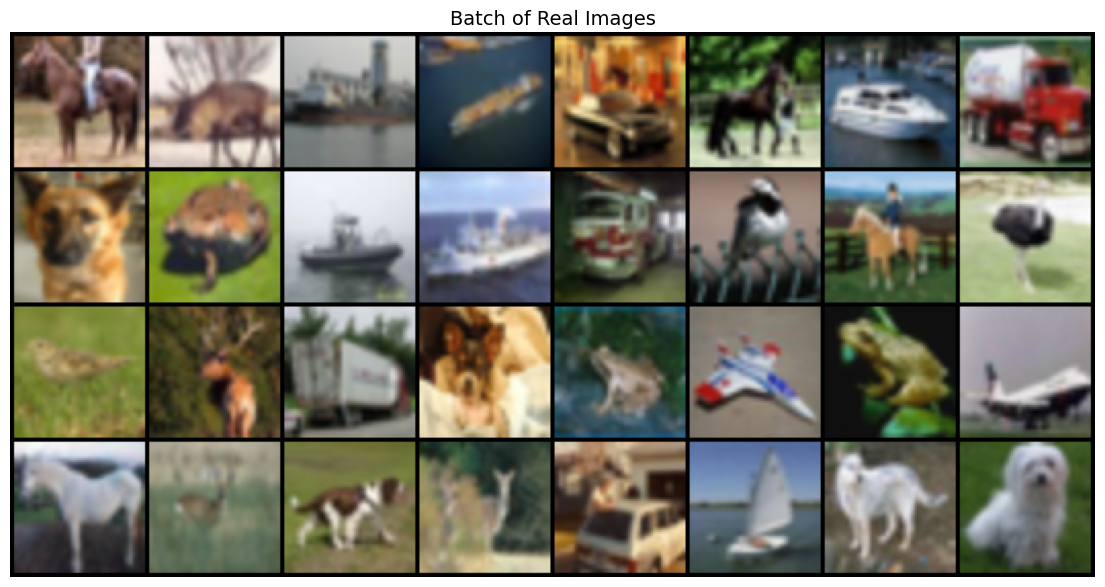

In [4]:
# Display a batch of real images from the data loader
batch_of_real_images = next(iter(data_loader))
plt.figure(figsize=(14, 8))
plt.axis("off")
plt.title("Batch of Real Images", fontsize=14)
plt.imshow(
    np.transpose(
        vision_utils.make_grid(
            batch_of_real_images[0].to(compute_device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0)
    )
)



In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, disc_features):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: N x img_channels x 64 x 64
            nn.Conv2d(img_channels, disc_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),

            self.build_block(disc_features, disc_features * 2, kernel_size=4, stride=2, padding=1),
            self.build_block(disc_features * 2, disc_features * 4, kernel_size=4, stride=2, padding=1),
            self.build_block(disc_features * 4, disc_features * 8, kernel_size=4, stride=2, padding=1),

            nn.Conv2d(disc_features * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def build_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(negative_slope=0.2),
        )

    def forward(self, input_tensor):
        return self.model(input_tensor)


In [6]:
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, gen_features):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Generator blocks
            self.build_block(noise_channels, gen_features * 16, kernel_size=4, stride=1, padding=0),
            self.build_block(gen_features * 16, gen_features * 8, kernel_size=4, stride=2, padding=1),
            self.build_block(gen_features * 8, gen_features * 4, kernel_size=4, stride=2, padding=1),
            self.build_block(gen_features * 4, gen_features * 2, kernel_size=4, stride=2, padding=1),

            # Output block
            nn.ConvTranspose2d(
                gen_features * 2, img_channels, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def build_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                input_channels,
                output_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(output_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, input_tensor):
        return self.model(input_tensor)


In [7]:
def init_weights(model):
    """
    Initialize model weights as per DCGAN guidelines.
    Reference: https://arxiv.org/abs/1511.06434
    """
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data, mean=0.0, std=0.02)

# Create generator and discriminator models
generator = Generator(noise_channels=100, img_channels=3, gen_features=64).to(compute_device)
discriminator = Discriminator(img_channels=3, disc_features=64).to(compute_device)

# Initialize model weights
init_weights(generator)
init_weights(discriminator)

# Define learning rate
learning_rate = 2e-4

print('Model initialization completed...')


Model initialization completed...


In [8]:
# Define optimizers for the generator and discriminator
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss function
loss_function = nn.BCELoss()

# Generate fixed noise for evaluation
fixed_latent_noise = torch.randn(32, 100, 1, 1).to(compute_device)

# Initialize step counter
training_step = 0

# Set discriminator to training mode
discriminator.train()


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [9]:
# Set the generator to training mode
generator.train()



Generator(
  (model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3

In [10]:
def matrix_sqrt_approximation(matrix, method='scaling_squaring'):
    """
    Approximates the square root of a matrix using the specified method.

    Parameters:
    - matrix: Input square matrix (numpy array)
    - method: Method to use for approximation ('scaling_squaring' or 'power_iteration')

    Returns:
    - Approximate square root of the matrix
    """
    if method == 'scaling_squaring':
        # Scaling and squaring approach
        U, singular_values, V = np.linalg.svd(matrix)
        singular_values = np.diag(np.sqrt(singular_values))
        return U.dot(singular_values).dot(V)
    elif method == 'power_iteration':
        # Power iteration approach
        max_iterations = 100
        tolerance = 1e-6
        approximation = np.eye(matrix.shape[0])
        for iteration in range(max_iterations):
            next_approximation = 0.5 * (approximation + matrix.dot(np.linalg.inv(approximation)))
            if np.max(np.abs(approximation - next_approximation)) < tolerance:
                break
            approximation = next_approximation
        return approximation
    else:
        raise ValueError(f"Unsupported method: {method}")


In [11]:
class InceptionV3Wrapper(nn.Module):
    """Wrapper for Pretrained InceptionV3 to extract feature maps."""

    # Default block index for final average pooling
    DEFAULT_OUTPUT_BLOCK = 3

    # Mapping from feature dimensionality to output block indices
    DIMENSION_TO_BLOCK = {
        64: 0,    # Features after the first max pool
        192: 1,   # Features after the second max pool
        768: 2,   # Pre-auxiliary classifier features
        2048: 3   # Final average pooling features
    }

    def __init__(self, 
                 output_blocks=None, 
                 resize_input=True, 
                 normalize_input=True, 
                 requires_grad=False):
        super(InceptionV3Wrapper, self).__init__()

        # Settings
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks or [self.DEFAULT_OUTPUT_BLOCK])
        self.max_output_block = max(self.output_blocks)

        # Validate output block range
        assert self.max_output_block <= 3, "Maximum block index is 3"

        # Define blocks as a ModuleList
        self.feature_blocks = nn.ModuleList()

        pretrained_inception = models.inception_v3(pretrained=True)

        # Define each block
        # Block 0: Input to the first max pool
        block_0 = [
            pretrained_inception.Conv2d_1a_3x3,
            pretrained_inception.Conv2d_2a_3x3,
            pretrained_inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.feature_blocks.append(nn.Sequential(*block_0))

        # Block 1: First max pool to second max pool
        if self.max_output_block >= 1:
            block_1 = [
                pretrained_inception.Conv2d_3b_1x1,
                pretrained_inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.feature_blocks.append(nn.Sequential(*block_1))

        # Block 2: Second max pool to auxiliary classifier
        if self.max_output_block >= 2:
            block_2 = [
                pretrained_inception.Mixed_5b,
                pretrained_inception.Mixed_5c,
                pretrained_inception.Mixed_5d,
                pretrained_inception.Mixed_6a,
                pretrained_inception.Mixed_6b,
                pretrained_inception.Mixed_6c,
                pretrained_inception.Mixed_6d,
                pretrained_inception.Mixed_6e,
            ]
            self.feature_blocks.append(nn.Sequential(*block_2))

        # Block 3: Auxiliary classifier to final average pool
        if self.max_output_block >= 3:
            block_3 = [
                pretrained_inception.Mixed_7a,
                pretrained_inception.Mixed_7b,
                pretrained_inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.feature_blocks.append(nn.Sequential(*block_3))

        # Set gradient requirements
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, input_tensor):
        feature_outputs = []
        x = input_tensor

        # Resize input if required
        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        # Normalize input to range (-1, 1)
        if self.normalize_input:
            x = 2 * x - 1

        # Extract features block by block
        for idx, block in enumerate(self.feature_blocks):
            x = block(x)
            if idx in self.output_blocks:
                feature_outputs.append(x)

            if idx == self.max_output_block:
                break

        return feature_outputs


# Initialize the model with the desired block index
feature_block_idx = InceptionV3Wrapper.DIMENSION_TO_BLOCK[2048]
inception_model = InceptionV3Wrapper(output_blocks=[feature_block_idx]).cuda()


/home/snarale/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/snarale/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def compute_activation_statistics(images, model, batch_size=128, feature_dim=2048, use_cuda=False):
    """
    Computes the activation statistics (mean and covariance) for a batch of images using the specified model.

    Parameters:
    - images: Input batch of images.
    - model: Pretrained model for feature extraction.
    - batch_size: Number of images per batch.
    - feature_dim: Dimensionality of the features to extract.
    - use_cuda: Whether to use GPU acceleration.

    Returns:
    - mean: Mean of the features.
    - covariance: Covariance of the features.
    """
    model.eval()
    activations = np.empty((len(images), feature_dim))
    
    # Move images to the appropriate device
    batch = images.cuda() if use_cuda else images
    features = model(batch)[0]
    
    # Apply global average pooling if necessary
    if features.size(2) != 1 or features.size(3) != 1:
        features = F.adaptive_avg_pool2d(features, output_size=(1, 1))

    activations = features.cpu().data.numpy().reshape(features.size(0), -1)
    mean = np.mean(activations, axis=0)
    covariance = np.cov(activations, rowvar=False)
    return mean, covariance


def compute_frechet_distance(mean1, cov1, mean2, cov2, epsilon=1e-6):
    """
    Computes the Frechet Distance between two Gaussian distributions.

    Parameters:
    - mean1: Mean of the first distribution.
    - cov1: Covariance matrix of the first distribution.
    - mean2: Mean of the second distribution.
    - cov2: Covariance matrix of the second distribution.
    - epsilon: Small constant to stabilize computations.

    Returns:
    - Frechet distance value.
    """
    mean1 = np.atleast_1d(mean1)
    mean2 = np.atleast_1d(mean2)
    cov1 = np.atleast_2d(cov1)
    cov2 = np.atleast_2d(cov2)

    # Validate dimensions
    assert mean1.shape == mean2.shape, "Mean vectors have different dimensions"
    assert cov1.shape == cov2.shape, "Covariance matrices have different dimensions"

    mean_diff = mean1 - mean2
    sqrt_covariance = matrix_sqrt_approximation(cov1.dot(cov2), method='scaling_squaring')

    if not np.isfinite(sqrt_covariance).all():
        print(f"Covariance product is not finite. Adjusting with epsilon={epsilon}.")
        offset = np.eye(cov1.shape[0]) * epsilon
        sqrt_covariance = matrix_sqrt_approximation((cov1 + offset).dot(cov2 + offset), method='scaling_squaring')

    # Handle complex outputs
    if np.iscomplexobj(sqrt_covariance):
        if not np.allclose(np.diagonal(sqrt_covariance).imag, 0, atol=1e-3):
            max_imag = np.max(np.abs(sqrt_covariance.imag))
            raise ValueError(f"Imaginary component in result: {max_imag}")
        sqrt_covariance = sqrt_covariance.real

    trace_sqrt_cov = np.trace(sqrt_covariance)

    return mean_diff.dot(mean_diff) + np.trace(cov1) + np.trace(cov2) - 2 * trace_sqrt_cov


def compute_fid(real_images, fake_images, model):
    """
    Computes the Frechet Inception Distance (FID) between real and fake images.

    Parameters:
    - real_images: Batch of real images.
    - fake_images: Batch of fake images generated by the model.
    - model: Pretrained model for feature extraction.

    Returns:
    - FID score.
    """
    real_mean, real_cov = compute_activation_statistics(real_images, model, use_cuda=True)
    fake_mean, fake_cov = compute_activation_statistics(fake_images, model, use_cuda=True)
    fid_score = compute_frechet_distance(real_mean, real_cov, fake_mean, fake_cov)
    return fid_score


In [13]:
# Initialize training metrics
gen_loss_history = []
disc_loss_history = []
generated_images = []
fid_scores = []
training_iterations = 0
total_epochs = 50


In [18]:
print("Starting training...")

start_time = time.time()

for epoch_idx in range(1, total_epochs + 1):
    for batch_idx, batch_data in enumerate(data_loader, 0):
        
        real_images = batch_data[0].to(compute_device)
        latent_noise = torch.randn(128, 100, 1, 1).to(compute_device)
        generated_images_batch = generator(latent_noise)

        # Train the discriminator
        real_predictions = discriminator(real_images).view(-1)
        real_loss = loss_function(real_predictions, torch.ones_like(real_predictions))
        fake_predictions = discriminator(generated_images_batch.detach()).view(-1)
        fake_loss = loss_function(fake_predictions, torch.zeros_like(fake_predictions))
        disc_loss = (real_loss + fake_loss) / 2
        discriminator.zero_grad()
        disc_loss.backward()
        discriminator_optimizer.step()

        # Train the generator
        gen_output = discriminator(generated_images_batch).view(-1)
        gen_loss = loss_function(gen_output, torch.ones_like(gen_output))
        generator.zero_grad()
        gen_loss.backward()
        generator_optimizer.step()

        # Record losses
        gen_loss_history.append(gen_loss.detach().cpu())
        disc_loss_history.append(disc_loss.detach().cpu())

        # Save generated images at intervals
        if (training_iterations % 500 == 0) or ((epoch_idx == total_epochs) and (batch_idx == len(data_loader) - 1)):
            with torch.no_grad():
                generated_images_eval = generator(fixed_latent_noise).detach().cpu()
            generated_images.append(vision_utils.make_grid(generated_images_eval, padding=2, normalize=True))

        training_iterations += 1

    # Compute FID
    fid_score = compute_fid(real_images, generated_images_batch, inception_model)
    fid_scores.append(fid_score)

    # Log progress every 5 epochs
    if epoch_idx % 5 == 0:
        print(f"Epoch: [{epoch_idx}/{total_epochs}] Batch: {batch_idx}/{len(data_loader)} "
              f"Discriminator Loss: {disc_loss:.3f}, Generator Loss: {gen_loss:.3f}, FID: {fid_score:.3f}")

    # Save generated and real images for the current epoch
    os.makedirs('./dcgan_images/fake', exist_ok=True)
    os.makedirs('./dcgan_images/real', exist_ok=True)
    vision_utils.save_image(generated_images_batch.detach(), f'./dcgan_images/fake/DCGAN_epoch_{epoch_idx:03d}.png', normalize=True)
    vision_utils.save_image(real_images.detach(), f'./dcgan_images/real/DCGAN_epoch_{epoch_idx:03d}.png', normalize=True)

end_time = time.time()
print(f'Total training time: {end_time - start_time:.2f} seconds.')


Starting training...
Epoch: [5/50] Batch: 1562/1563 Discriminator Loss: 0.649, Generator Loss: 1.168, FID: 272.486
Epoch: [10/50] Batch: 1562/1563 Discriminator Loss: 0.562, Generator Loss: 0.870, FID: 282.205
Epoch: [15/50] Batch: 1562/1563 Discriminator Loss: 0.392, Generator Loss: 1.273, FID: 309.076
Epoch: [20/50] Batch: 1562/1563 Discriminator Loss: 0.593, Generator Loss: 1.175, FID: 281.409
Epoch: [25/50] Batch: 1562/1563 Discriminator Loss: 0.399, Generator Loss: 1.679, FID: 293.827
Epoch: [30/50] Batch: 1562/1563 Discriminator Loss: 0.344, Generator Loss: 2.258, FID: 298.098
Epoch: [35/50] Batch: 1562/1563 Discriminator Loss: 0.316, Generator Loss: 2.884, FID: 287.996
Epoch: [40/50] Batch: 1562/1563 Discriminator Loss: 0.242, Generator Loss: 3.505, FID: 303.575
Epoch: [45/50] Batch: 1562/1563 Discriminator Loss: 0.160, Generator Loss: 3.876, FID: 305.275
Epoch: [50/50] Batch: 1562/1563 Discriminator Loss: 0.174, Generator Loss: 3.688, FID: 304.986
Total training time: 5063.45 s

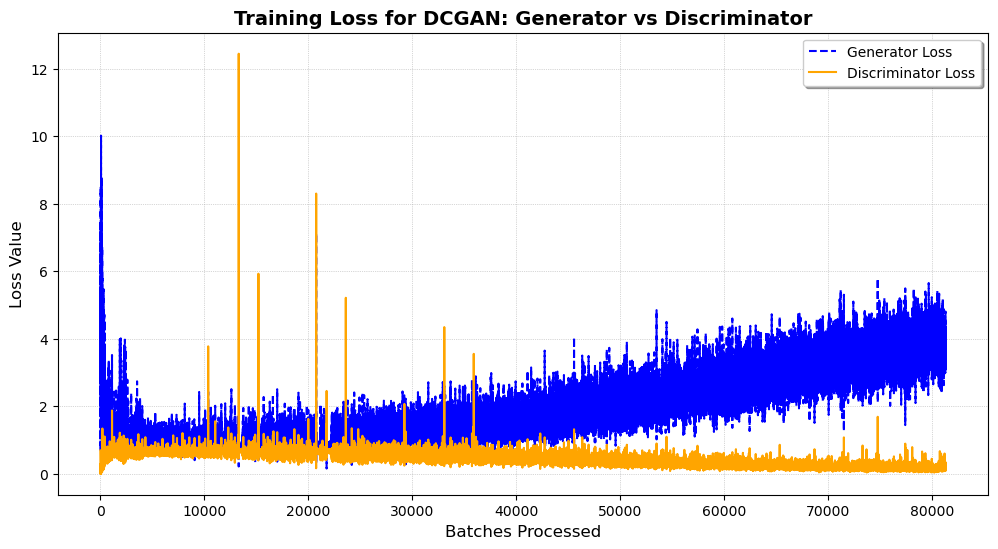

In [20]:
plt.figure(figsize=(12, 6))  # Slightly larger figure size
plt.title("Training Loss for DCGAN: Generator vs Discriminator", fontsize=14, fontweight='bold')
plt.plot(gen_loss_history, label="Generator Loss", linestyle='--', linewidth=1.5, color='blue')
plt.plot(disc_loss_history, label="Discriminator Loss", linestyle='-', linewidth=1.5, color='orange')
plt.xlabel("Batches Processed", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.legend(loc="upper right", fontsize=10, shadow=True)
plt.grid(visible=True, linestyle=':', linewidth=0.5)  # Added 


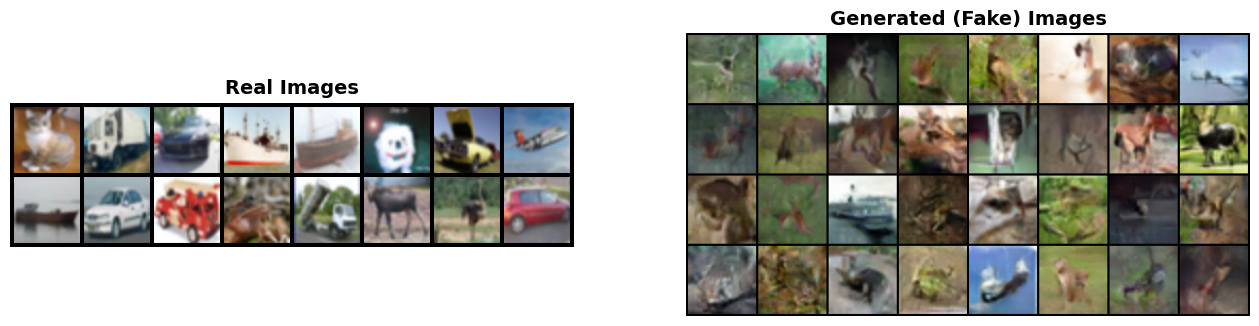

In [21]:
plt.figure(figsize=(16, 10))  # Adjusted figure size for a more horizontal layout

# Display real images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images", fontsize=14, fontweight='bold')
plt.imshow(
    np.transpose(
        vision_utils.make_grid(
            real_images[:64].to(compute_device), padding=4, normalize=True
        ).cpu(),
        (1, 2, 0)
    )
)

# Display fake images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Generated (Fake) Images", fontsize=14, fontweight='bold')
plt.imshow(np.transpose(generated_images[-1], (1, 2, 0)))

# Save the comparison plot
os.makedirs('./dcgan_images', exist_ok=True)
plt.savefig('./dcgan_images/comparison.png', format='png', bbox_inches='tight', dpi=150)
plt.show()


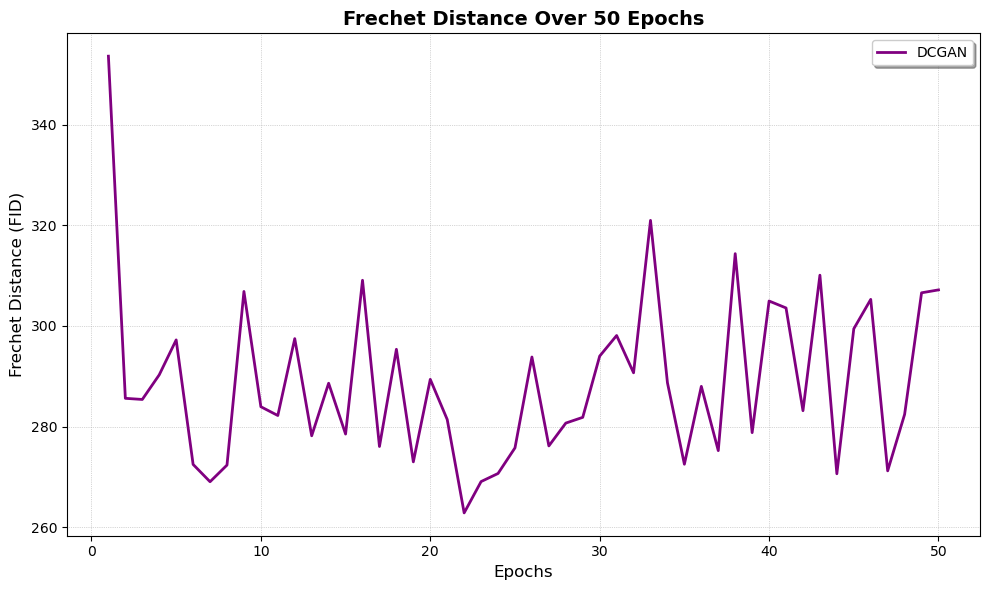

In [23]:
# Ensure fid_scores matches the number of epochs
fid_scores = fid_scores[:total_epochs]  # Truncate to match total_epochs if necessary

# Plot Frechet Distance over 50 epochs
plt.figure(figsize=(10, 6))
plt.plot(
    np.arange(1, total_epochs + 1), fid_scores, 
    label='DCGAN', linestyle='-', linewidth=2, color='purple'
)
plt.title('Frechet Distance Over 50 Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Frechet Distance (FID)', fontsize=12)
plt.legend(loc='upper right', fontsize=10, shadow=True)
plt.grid(visible=True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()
